In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
df_delivery = pd.read_csv('../01_CSV Trabajo/df_delivery_limpio.csv')

In [50]:
# Verificar las primeras filas del dataframe
df_delivery.head()

,store_primary_category,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_duration,partner_density,order_day,order_hour,order_period,busy_ratio,avg_item_price,order_size,grouped_category
0,american,4,3441,4,557,1239,33.0,14.0,21.0,3779.0,1.500000,Friday,22,Night,0.411765,860.25,Medium,American
1,mexican,1,1900,1,1400,1400,1.0,2.0,2.0,4024.0,0.333333,Tuesday,21,Evening,1.000000,1900.00,Small,Mexican
2,indian,4,4771,3,820,1604,8.0,6.0,18.0,1586.0,0.421053,Monday,0,Night,0.666667,1192.75,Medium,Indian
3,italian,1,1525,1,1525,1525,5.0,6.0,8.0,2273.0,0.555556,Thursday,3,Night,1.000000,1525.00,Small,Italian
4,italian,2,3620,2,1425,2195,5.0,5.0,7.0,2988.0,0.625000,Tuesday,2,Night,0.833333,1810.00,Small,Italian


In [51]:
# Quiero prededir el tiempo de entrega de un pedido
# Me baso en las variables: categoría del restaurante, el número de repartidores activos, el total de órdenes pendientes,...


In [52]:
# Verificar información general del DataFrame
print(df_delivery.info())

# Estadísticas descriptivas
print(df_delivery.describe())

# Verificar valores nulos
print(df_delivery.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166468 entries, 0 to 166467
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   store_primary_category    166468 non-null  object 
 1   total_items               166468 non-null  int64  
 2   subtotal                  166468 non-null  int64  
 3   num_distinct_items        166468 non-null  int64  
 4   min_item_price            166468 non-null  int64  
 5   max_item_price            166468 non-null  int64  
 6   total_onshift_partners    166468 non-null  float64
 7   total_busy_partners       166468 non-null  float64
 8   total_outstanding_orders  166468 non-null  float64
 9   delivery_duration         166468 non-null  float64
 10  partner_density           166468 non-null  float64
 11  order_day                 166468 non-null  object 
 12  order_hour                166468 non-null  int64  
 13  order_period              166468 non-null  o

/Users/luismgl/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/luismgl/Library/Python/3.9/lib/python/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [53]:
# Verificar si hay valores nulos en el dataframe
missing_values = df_delivery.isnull().sum()

# Revisar valores únicos de las columnas categóricas para identificar inconsistencias
categorical_columns = ['grouped_category', 'order_day', 'order_period', 'order_size']
unique_values = {col: df_delivery[col].unique() for col in categorical_columns}

missing_values, unique_values


(store_primary_category      0
 total_items                 0
 subtotal                    0
 num_distinct_items          0
 min_item_price              0
 max_item_price              0
 total_onshift_partners      0
 total_busy_partners         0
 total_outstanding_orders    0
 delivery_duration           0
 partner_density             0
 order_day                   0
 order_hour                  0
 order_period                0
 busy_ratio                  0
 avg_item_price              0
 order_size                  0
 grouped_category            0
 dtype: int64,
 {'grouped_category': array(['American', 'Mexican', 'Indian', 'Italian', 'Fast Food', 'Asian',
         'Other', 'Healthy', 'Mediterranean', 'Latin', 'Desserts',
         'European', 'Beverages'], dtype=object),
  'order_day': array(['Friday', 'Tuesday', 'Monday', 'Thursday', 'Sunday', 'Saturday',
         'Wednesday'], dtype=object),
  'order_period': array(['Night', 'Evening', 'Morning', 'Afternoon'], dtype=object),
  'or

In [54]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [55]:
# Codificación de las columnas categóricas
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_delivery[col] = le.fit_transform(df_delivery[col])
    label_encoders[col] = le  # Guardar los encoders para referencia futura


In [56]:
# Normalización de columnas numéricas
numeric_columns = [
    'total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
    'max_item_price', 'total_onshift_partners', 'total_busy_partners',
    'total_outstanding_orders', 'partner_density', 'busy_ratio',
    'avg_item_price'
]

In [57]:
# Exportar las filas problemáticas para análisis externo (si necesario)
problematic_rows = df_delivery[
    (df_delivery['partner_density'] == float('inf')) | 
    (df_delivery['partner_density'] == -float('inf')) |
    (df_delivery['busy_ratio'] == float('inf')) | 
    (df_delivery['busy_ratio'] == -float('inf'))
]

# Eliminar filas problemáticas directamente
df_delivery = df_delivery[
    ~((df_delivery['partner_density'] == float('inf')) | 
      (df_delivery['partner_density'] == -float('inf')) |
      (df_delivery['busy_ratio'] == float('inf')) | 
      (df_delivery['busy_ratio'] == -float('inf')))
]

# Eliminar valores NaN en las columnas problemáticas
df_delivery.dropna(subset=['partner_density', 'busy_ratio'], inplace=True)

# Verificar si los problemas se resolvieron
cleaned_partner_density_issues = df_delivery['partner_density'].isna().sum()
cleaned_busy_ratio_issues = df_delivery['busy_ratio'].isna().sum()

cleaned_partner_density_issues, cleaned_busy_ratio_issues, df_delivery.shape


(np.int64(0), np.int64(0), (166448, 18))

In [58]:
from sklearn.model_selection import train_test_split

# Definir la variable objetivo y las características predictoras
target = 'delivery_duration'
excluded_columns = ['store_primary_category', 'delivery_duration']  # Columnas irrelevantes o la target
features = [col for col in df_delivery.columns if col not in excluded_columns]

In [59]:
# Dividir los datos en entrenamiento (80%) y prueba (20%)
X = df_delivery[features]
y = df_delivery[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Verificar las dimensiones de los conjuntos
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((133158, 16), (33290, 16), (133158,), (33290,))

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [62]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

In [63]:
# Calcular métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [64]:
mae, mse, r2

(672.0149950083264, 744605.7504211, 0.19660434578085373)

In [65]:
# Voy a revisar correlaciones entre características y la variable objetivo

In [66]:
import matplotlib.pyplot as plt

# Excluyo columnas categóricas para el cálculo de la matriz de correlación
numeric_columns = df_delivery.select_dtypes(include=['float64', 'int64']).columns

In [67]:
# Calculo la matriz de correlación solo con las columnas numéricas
correlation_matrix = df_delivery[numeric_columns].corr()

In [68]:
# Extraer las correlaciones con la variable objetivo
target_correlation = correlation_matrix['delivery_duration'].sort_values(ascending=False)

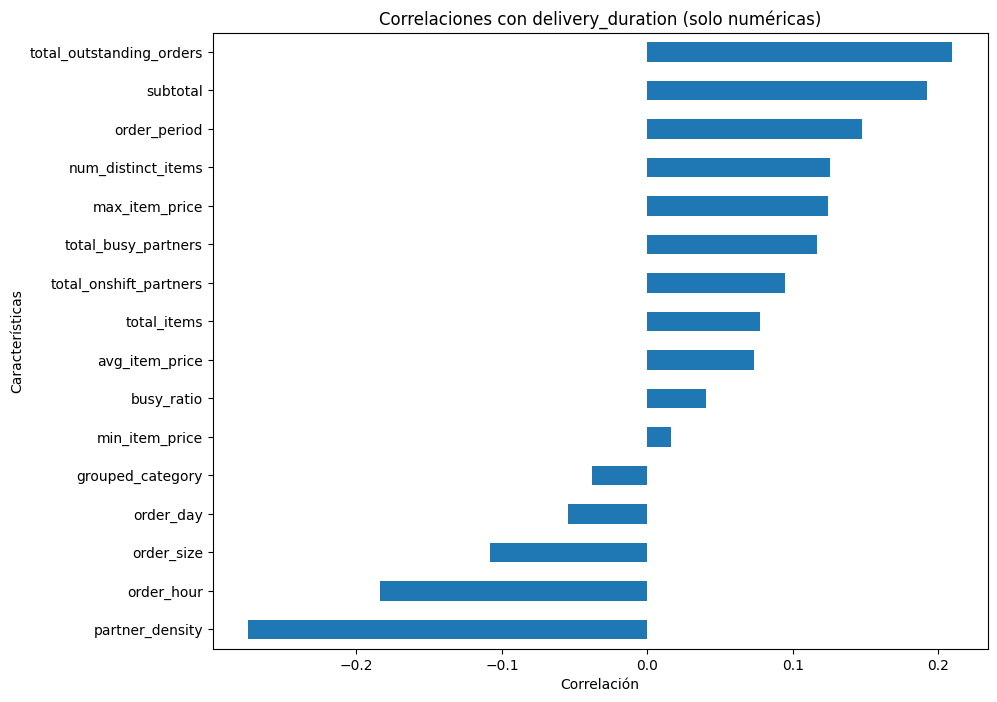

In [69]:
# Visualizar las correlaciones más altas y bajas
plt.figure(figsize=(10, 8))
plt.title('Correlaciones con delivery_duration (solo numéricas)')
target_correlation.drop('delivery_duration').sort_values().plot(kind='barh')
plt.xlabel('Correlación')
plt.ylabel('Características')
plt.show()

In [70]:
target_correlation

delivery_duration           1.000000
total_outstanding_orders    0.209640
subtotal                    0.191895
order_period                0.147286
num_distinct_items          0.125520
max_item_price              0.124202
total_busy_partners         0.116261
total_onshift_partners      0.094352
total_items                 0.077570
avg_item_price              0.073060
busy_ratio                  0.040433
min_item_price              0.016429
grouped_category           -0.037769
order_day                  -0.054452
order_size                 -0.108197
order_hour                 -0.183474
partner_density            -0.274555
Name: delivery_duration, dtype: float64

Correlaciones más altas con delivery_duration (positivas):
    total_outstanding_orders (0.21): Relación positiva fuerte con tiempos de entrega.
    subtotal (0.19): Los pedidos más caros tienden a tardar más.
    order_period (0.15): El momento del día afecta los tiempos.
Correlaciones más bajas con delivery_duration (negativas):
    partner_density (-0.27): Más repartidores disponibles reduce los tiempos.
    order_hour (-0.18): A ciertas horas, los tiempos son más rápidos.
    order_size (-0.11): Pedidos pequeños tienden a ser más rápidos.

In [71]:
# Elimino características con correlaciones bajas o irrelevantes
irrelevantes_columns = ['grouped_category', 'order_day']
X = X.drop(columns=irrelevantes_columns)

In [72]:
# Actualizo los conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [73]:
# Verificar las dimensiones después de eliminar las columnas
X_train.shape, X_test.shape

((133158, 14), (33290, 14))

In [74]:
from xgboost import XGBRegressor

# Creo y entreno el modelo XGBoost
xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_model.fit(X_train, y_train)

# Realizo predicciones en el conjunto de prueba
y_pred_xgb = xgb_model.predict(X_test)

# Calculo métricas de evaluación para XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

mae_xgb, mse_xgb, r2_xgb


(639.1214720469618, 681840.4102579, 0.2643252860155806)

In [75]:
from sklearn.ensemble import RandomForestRegressor

# Creo un modelo Random Forest con parámetros ajustados
rf_model = RandomForestRegressor(
    random_state=42,
    n_estimators=200, 
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    n_jobs=-1
)

In [76]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200, n_jobs=-1, random_state=42)

In [77]:
# Realizo predicciones en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

In [78]:
# Calcular métricas de evaluación para Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mae_rf, mse_rf, r2_rf

(643.7252280001263, 691398.0203180253, 0.254013060542324)

In [79]:
#Voy a intentar modificar de nuevo las características para que llegue a un mejor resultado

In [80]:
# Creo nuevas características derivadas
df_delivery['orders_per_busy_partner'] = df_delivery['total_outstanding_orders'] / (df_delivery['total_busy_partners'] + 1)
df_delivery['avg_item_value'] = df_delivery['subtotal'] / (df_delivery['num_distinct_items'] + 1)

In [81]:
df_delivery.fillna(0, inplace=True)

In [82]:
# Actualizo las características y la variable objetivo
new_features = ['orders_per_busy_partner', 'avg_item_value']
X = df_delivery.drop(columns=['store_primary_category', 'delivery_duration', 'grouped_category', 'order_day'])
X = pd.concat([X, df_delivery[new_features]], axis=1)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, df_delivery['delivery_duration'], test_size=0.2, random_state=42)

In [84]:
X_train.shape, X_test.shape

((133158, 18), (33290, 18))

In [85]:
# Corrijo los valores negativos y extremos en las columnas problemáticas
X['busy_ratio'] = X['busy_ratio'].clip(lower=0, upper=1)  # Limitar entre 0 y 1
X['partner_density'] = X['partner_density'].clip(lower=0, upper=5)  # Limitar entre 0 y 5

In [86]:
# Verifico las estadísticas después de limpiar
cleaned_stats = X[['busy_ratio', 'partner_density']].describe()

cleaned_stats

,busy_ratio,partner_density
count,166448.000000,166448.000000
mean,0.839192,0.877004
std,0.206063,0.408080
min,-0.000000,0.000000
25%,0.770270,0.652778
50%,0.916667,0.800000
75%,0.981818,1.000000
max,1.000000,5.000000


In [87]:
# Verificar y eliminar valores infinitos o extremos en todas las columnas de entrada
X_cleaned = X.replace([float('inf'), -float('inf')], pd.NA).fillna(0)  # Reemplazar infinitos por 0
X_cleaned = X_cleaned.clip(lower=0)  # Eliminar valores negativos

# Revisar estadísticas después de la limpieza
cleaned_stats_full = X_cleaned.describe()

# Actualizar conjuntos de entrenamiento y prueba con los datos limpios
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    X_cleaned, df_delivery['delivery_duration'], test_size=0.2, random_state=42
)

cleaned_stats_full, X_train_cleaned.shape, X_test_cleaned.shape


/var/folders/41/9xs275yn7jxbs_h59j3pq3sw0000gn/T/ipykernel_56261/4184435473.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_cleaned = X.replace([float('inf'), -float('inf')], pd.NA).fillna(0)  # Reemplazar infinitos por 0


(         total_items       subtotal  num_distinct_items  min_item_price  \
 count  166448.000000  166448.000000       166448.000000   166448.000000   
 mean        2.978588    2422.128136            2.516966      684.593272   
 std         2.390138    1315.842475            1.398214      510.170140   
 min         1.000000       0.000000            1.000000        0.000000   
 25%         2.000000    1390.000000            1.000000      299.000000   
 50%         2.000000    2145.000000            2.000000      595.000000   
 75%         4.000000    3199.000000            3.000000      949.000000   
 max       411.000000    6405.000000           15.000000     6400.000000   
 
        max_item_price  total_onshift_partners  total_busy_partners  \
 count   166448.000000           166448.000000        166448.000000   
 mean      1127.039928               44.659744            41.620837   
 std        516.046066               34.480454            32.118327   
 min          0.000000        

In [88]:
# Realizar una limpieza final en las muestras de entrenamiento y prueba
X_train_sample = X_train_sample.replace([float('inf'), -float('inf')], pd.NA).fillna(0).clip(lower=0)
X_test_sample = X_test_sample.replace([float('inf'), -float('inf')], pd.NA).fillna(0).clip(lower=0)

# Entrenar nuevamente el modelo de Árbol de Decisión
dt_model_cleaned = DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_split=10, min_samples_leaf=4)
dt_model_cleaned.fit(X_train_sample, y_train_sample)

# Realizar predicciones en el conjunto de prueba limpio
y_pred_dt_cleaned = dt_model_cleaned.predict(X_test_sample)

# Calcular métricas de evaluación
mae_dt_cleaned = mean_absolute_error(y_test_sample, y_pred_dt_cleaned)
mse_dt_cleaned = mean_squared_error(y_test_sample, y_pred_dt_cleaned)
r2_dt_cleaned = r2_score(y_test_sample, y_pred_dt_cleaned)

mae_dt_cleaned, mse_dt_cleaned, r2_dt_cleaned


NameError: name 'X_train_sample' is not defined

In [44]:
from lightgbm import LGBMRegressor

# Eliminar columnas duplicadas en el conjunto de datos
X_train_sample = X_train_sample.loc[:, ~X_train_sample.columns.duplicated()]
X_test_sample = X_test_sample.loc[:, ~X_test_sample.columns.duplicated()]

# Entrenar nuevamente el modelo LightGBM con las características únicas
lgbm_model_cleaned = LGBMRegressor(
    random_state=42,
    n_estimators=100,  # Número de árboles
    learning_rate=0.1,  # Tasa de aprendizaje
    max_depth=7,  # Profundidad máxima
    min_child_weight=3  # Control de sobreajuste
)
lgbm_model_cleaned.fit(X_train_sample, y_train_sample)

# Realizar predicciones en el conjunto de prueba
y_pred_lgbm_cleaned = lgbm_model_cleaned.predict(X_test_sample)

# Calcular métricas de evaluación
mae_lgbm_cleaned = mean_absolute_error(y_test_sample, y_pred_lgbm_cleaned)
mse_lgbm_cleaned = mean_squared_error(y_test_sample, y_pred_lgbm_cleaned)
r2_lgbm_cleaned = r2_score(y_test_sample, y_pred_lgbm_cleaned)

mae_lgbm_cleaned, mse_lgbm_cleaned, r2_lgbm_cleaned


NameError: name 'X_train_sample' is not defined

In [45]:
from sklearn.model_selection import RandomizedSearchCV

# Espacio de búsqueda de hiperparámetros
param_distributions = {
    'max_iter': [50, 100, 200],  # Número de iteraciones
    'max_depth': [5, 7, 10],  # Profundidad máxima
    'learning_rate': [0.01, 0.1, 0.2],  # Tasa de aprendizaje
    'min_samples_leaf': [5, 10, 20]  # Mínimo de muestras por hoja
}


In [46]:
# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=HistGradientBoostingRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,  # Número de combinaciones a probar
    scoring='r2',  # Maximizar R²
    cv=3,  # Validación cruzada con 3 particiones
    verbose=1,
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

NameError: name 'HistGradientBoostingRegressor' is not defined

In [47]:
# Ejecutar la búsqueda
random_search.fit(X_train_sample, y_train_sample)

# Obtener los mejores parámetros y resultados
best_params = random_search.best_params_
best_score = random_search.best_score_

best_params, best_score

NameError: name 'random_search' is not defined

In [135]:
# Intentar cargar nuevamente el archivo proporcionado
file_path = 'df_delivery_limpio.csv'
df_delivery = pd.read_csv(file_path)

# Verificar la estructura y contenido del dataset cargado
df_delivery.info(), df_delivery.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166468 entries, 0 to 166467
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   store_primary_category    166468 non-null  object 
 1   total_items               166468 non-null  int64  
 2   subtotal                  166468 non-null  int64  
 3   num_distinct_items        166468 non-null  int64  
 4   min_item_price            166468 non-null  int64  
 5   max_item_price            166468 non-null  int64  
 6   total_onshift_partners    166468 non-null  float64
 7   total_busy_partners       166468 non-null  float64
 8   total_outstanding_orders  166468 non-null  float64
 9   delivery_duration         166468 non-null  float64
 10  partner_density           166468 non-null  float64
 11  order_day                 166468 non-null  object 
 12  order_hour                166468 non-null  int64  
 13  order_period              166468 non-null  o

(None,
   store_primary_category  total_items  subtotal  num_distinct_items  \
 0               american            4      3441                   4   
 1                mexican            1      1900                   1   
 2                 indian            4      4771                   3   
 3                italian            1      1525                   1   
 4                italian            2      3620                   2   
 
    min_item_price  max_item_price  total_onshift_partners  \
 0             557            1239                    33.0   
 1            1400            1400                     1.0   
 2             820            1604                     8.0   
 3            1525            1525                     5.0   
 4            1425            2195                     5.0   
 
    total_busy_partners  total_outstanding_orders  delivery_duration  \
 0                 14.0                      21.0             3779.0   
 1                  2.0                  

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Definir columnas irrelevantes y eliminar
irrelevant_columns = ['store_primary_category', 'delivery_duration', 'grouped_category', 'order_day', 'order_size', 'order_period']
target = 'delivery_duration'
features = [col for col in df_delivery.columns if col not in irrelevant_columns]

# Codificar variables categóricas relevantes
le = LabelEncoder()
df_delivery['order_period_encoded'] = le.fit_transform(df_delivery['order_period'])

# Agregar las columnas codificadas a las características
features += ['order_period_encoded']

# Dividir los datos en conjuntos de entrenamiento y prueba
X = df_delivery[features]
y = df_delivery[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar dimensiones de los conjuntos
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((133174, 13), (33294, 13), (133174,), (33294,))

In [137]:
from sklearn.experimental import enable_hist_gradient_boosting  # Activar HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

# Espacio de búsqueda de hiperparámetros
param_distributions = {
    'max_iter': [50, 100, 200],  # Número de iteraciones
    'max_depth': [5, 7, 10],  # Profundidad máxima
    'learning_rate': [0.01, 0.1, 0.2],  # Tasa de aprendizaje
    'min_samples_leaf': [5, 10, 20]  # Mínimo de muestras por hoja
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=HistGradientBoostingRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,  # Número de combinaciones a probar
    scoring='r2',  # Maximizar R²
    cv=3,  # Validación cruzada con 3 particiones
    verbose=1,
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ejecutar la búsqueda
random_search.fit(X_train, y_train)

# Obtener los mejores parámetros y resultados
best_params = random_search.best_params_
best_score = random_search.best_score_

best_params, best_score


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/luismgl/Library/Python/3.9/lib/python/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


({'min_samples_leaf': 20,
  'max_iter': 200,
  'max_depth': 5,
  'learning_rate': 0.1},
 np.float64(0.25803356044273507))

In [138]:
# Entrenar el modelo con los mejores hiperparámetros encontrados
hgb_optimized = HistGradientBoostingRegressor(
    random_state=42,
    min_samples_leaf=20,
    max_iter=200,
    max_depth=5,
    learning_rate=0.1
)
hgb_optimized.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_optimized = hgb_optimized.predict(X_test)

# Calcular métricas de evaluación
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

mae_optimized, mse_optimized, r2_optimized


(640.8106021064308, 685585.6587416659, 0.26569066721346024)

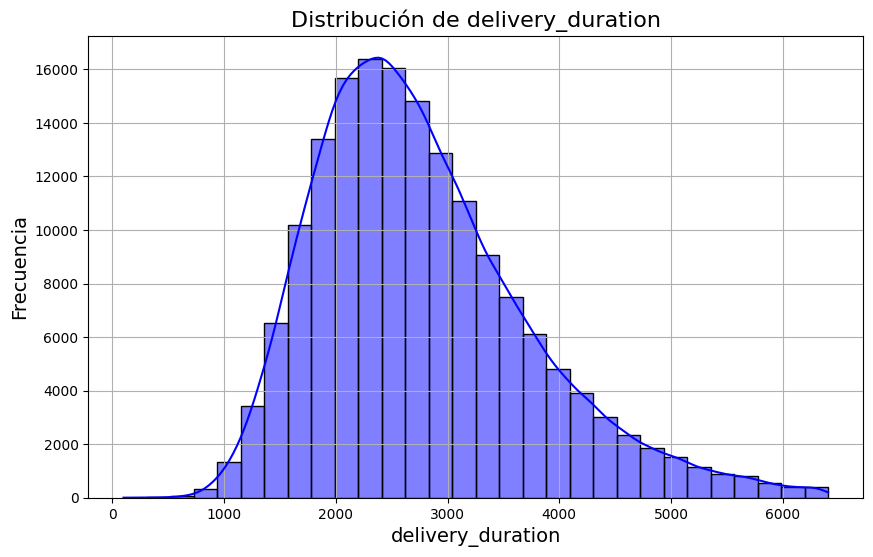

count    166468.000000
mean       2776.708310
std         967.289328
min         101.000000
25%        2079.000000
50%        2620.000000
75%        3309.000000
max        6405.000000
Name: delivery_duration, dtype: float64

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

# Revisar la distribución de la variable objetivo
plt.figure(figsize=(10, 6))
sns.histplot(df_delivery['delivery_duration'], kde=True, bins=30, color='blue')
plt.title('Distribución de delivery_duration', fontsize=16)
plt.xlabel('delivery_duration', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.grid(True)
plt.show()

# Calcular estadísticas descriptivas
df_delivery['delivery_duration'].describe()


In [ ]:
#Aplico una transformación logaritmica de la variable objetivo para mejorar la distribución

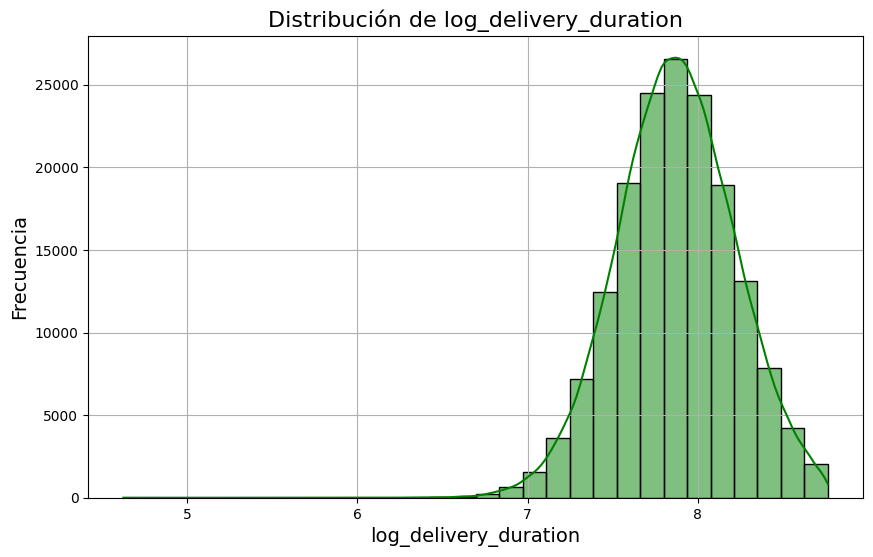

count    166468.000000
mean          7.870411
std           0.345646
min           4.624973
25%           7.640123
50%           7.871311
75%           8.104703
max           8.764990
Name: log_delivery_duration, dtype: float64

In [140]:
# Aplicar transformación logarítmica a la variable objetivo
import numpy as np

df_delivery['log_delivery_duration'] = np.log1p(df_delivery['delivery_duration'])  # log(1+x) para manejar valores 0

# Visualizar la nueva distribución
plt.figure(figsize=(10, 6))
sns.histplot(df_delivery['log_delivery_duration'], kde=True, bins=30, color='green')
plt.title('Distribución de log_delivery_duration', fontsize=16)
plt.xlabel('log_delivery_duration', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.grid(True)
plt.show()

# Verificar estadísticas descriptivas
df_delivery['log_delivery_duration'].describe()


In [ ]:
#Voy a ver outliers y a tratarlos para intentar dejar la variable objetivo más normalizada

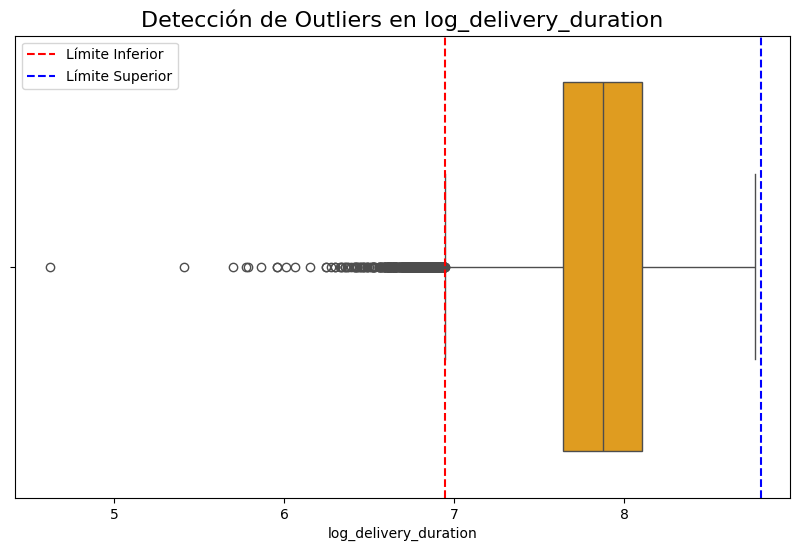

(830, np.float64(6.943252729181747), np.float64(8.801573911884724))

In [142]:
# Detectar valores atípicos utilizando el rango intercuartílico (IQR)
Q1 = df_delivery['log_delivery_duration'].quantile(0.25)
Q3 = df_delivery['log_delivery_duration'].quantile(0.75) 
IQR = Q3 - Q1 

# Definir límites para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar valores fuera de los límites
outliers = df_delivery[
    (df_delivery['log_delivery_duration'] < lower_bound) |
    (df_delivery['log_delivery_duration'] > upper_bound)
]

# Visualización de los outliers con un boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_delivery['log_delivery_duration'], color='orange')
plt.axvline(lower_bound, color='red', linestyle='--', label='Límite Inferior')
plt.axvline(upper_bound, color='blue', linestyle='--', label='Límite Superior')
plt.title('Detección de Outliers en log_delivery_duration', fontsize=16)
plt.legend()
plt.show()

# Cantidad de outliers detectados
outliers.shape[0], lower_bound, upper_bound


In [143]:
# Elimino las filas que contienen outliers
filtered_df = df_delivery[
    (df_delivery['log_delivery_duration'] >= 6.943252729181747) &
    (df_delivery['log_delivery_duration'] <= 8.801573911884724)
]

filtered_df.shape


(165638, 20)

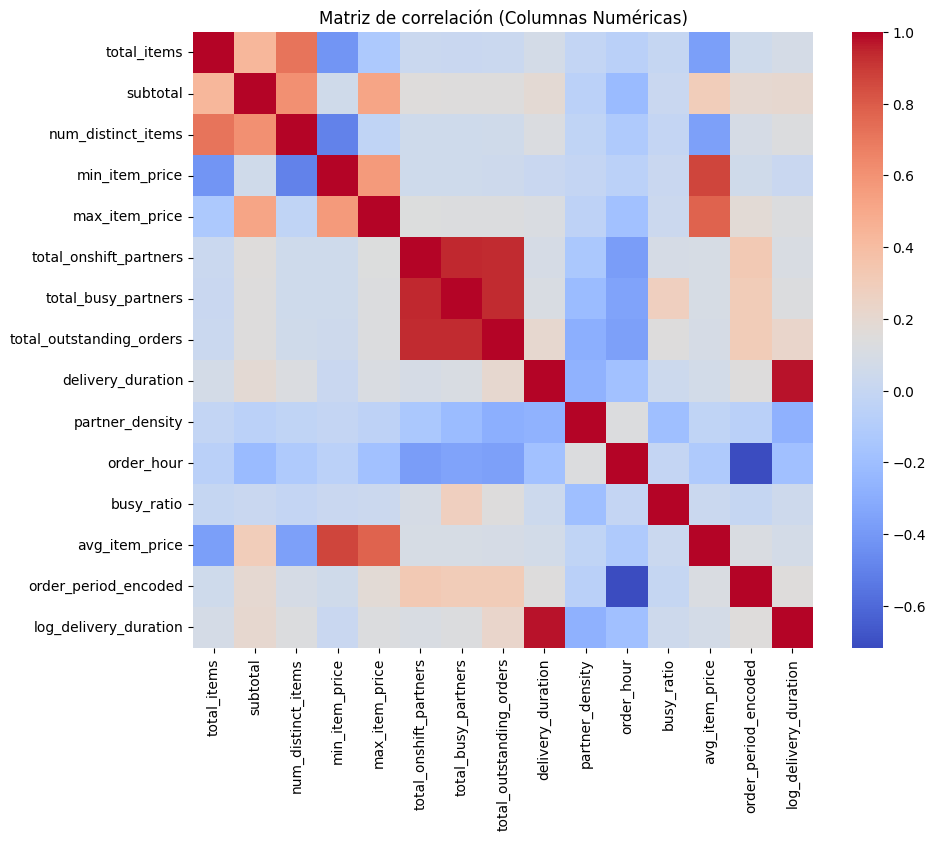

log_delivery_duration       1.000000
delivery_duration           0.976366
total_outstanding_orders    0.223875
subtotal                    0.203328
order_period_encoded        0.152651
num_distinct_items          0.133225
total_busy_partners         0.132475
max_item_price              0.130612
total_onshift_partners      0.111950
total_items                 0.082745
Name: log_delivery_duration, dtype: float64

In [145]:
# Seleccionar únicamente las columnas numéricas
numeric_columns = filtered_df.select_dtypes(include=['float64', 'int64']).columns

# Calcular la matriz de correlación con las columnas numéricas
correlation_matrix = filtered_df[numeric_columns].corr()
correlations_with_target = correlation_matrix['log_delivery_duration'].sort_values(ascending=False)

# Mostrar las 10 características más correlacionadas con la variable objetivo
top_correlations = correlations_with_target.head(10)

# Visualizar la matriz de correlación solo con columnas numéricas
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title('Matriz de correlación (Columnas Numéricas)')
plt.show()

top_correlations


In [146]:
# Seleccionar las características más relevantes basándonos en las correlaciones
relevant_features = [
    'total_outstanding_orders',
    'subtotal',
    'order_period_encoded',
    'num_distinct_items',
    'total_busy_partners',
    'max_item_price',
    'total_onshift_partners',
    'total_items'
]

# Crear un nuevo conjunto de datos ajustado con las características seleccionadas
X_adjusted = filtered_df[relevant_features]
y_adjusted = filtered_df['log_delivery_duration']

# Dividir los datos ajustados en entrenamiento y prueba
X_train_adjusted, X_test_adjusted, y_train_adjusted, y_test_adjusted = train_test_split(
    X_adjusted, y_adjusted, test_size=0.2, random_state=42
)

# Verificar las dimensiones después del ajuste
X_train_adjusted.shape, X_test_adjusted.shape, y_train_adjusted.shape, y_test_adjusted.shape


((132510, 8), (33128, 8), (132510,), (33128,))

In [148]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# Entrenar el modelo HistGradientBoostingRegressor con las características ajustadas
hgb_model_adjusted = HistGradientBoostingRegressor(
    random_state=42,
    min_samples_leaf=20,
    max_iter=200,
    max_depth=5,
    learning_rate=0.1
)
hgb_model_adjusted.fit(X_train_adjusted, y_train_adjusted)

# Realizar predicciones en el conjunto de prueba ajustado
y_pred_adjusted = hgb_model_adjusted.predict(X_test_adjusted)

# Calcular métricas de evaluación
mae_adjusted = mean_absolute_error(y_test_adjusted, y_pred_adjusted)
mse_adjusted = mean_squared_error(y_test_adjusted, y_pred_adjusted)
r2_adjusted = r2_score(y_test_adjusted, y_pred_adjusted)

print(f"MAE: {mae_adjusted}, MSE: {mse_adjusted}, R²: {r2_adjusted}")


MAE: 0.23472342485886663, MSE: 0.08687615148792986, R²: 0.23713938297494297


***VOY A ANALIZAR ERRORES PORQUE NO MEJORA***

In [149]:
# Análisis de errores: comparar predicciones vs valores reales
import pandas as pd

# Crear un DataFrame con valores reales y predicciones
error_analysis_df = pd.DataFrame({
    'Real': y_test_adjusted,
    'Predicción': y_pred_adjusted
})

# Calcular el error absoluto y relativo
error_analysis_df['Error Absoluto'] = abs(error_analysis_df['Real'] - error_analysis_df['Predicción'])
error_analysis_df['Error Relativo (%)'] = (error_analysis_df['Error Absoluto'] / error_analysis_df['Real']) * 100

# Descripción general de los errores
error_summary = error_analysis_df.describe()

# Identificar casos con mayores errores
top_errors = error_analysis_df.sort_values(by='Error Absoluto', ascending=False).head(10)

# Resultados
error_summary, top_errors

(               Real    Predicción  Error Absoluto  Error Relativo (%)
 count  33128.000000  33128.000000    33128.000000        33128.000000
 mean       7.873364      7.875310        0.234723            2.990545
 std        0.337469      0.161443        0.178275            2.287711
 min        6.945051      7.355511        0.000015            0.000191
 25%        7.641084      7.758114        0.093366            1.187461
 50%        7.870930      7.864167        0.197539            2.502511
 75%        8.104099      7.980762        0.339032            4.312476
 max        8.764990      8.587043        1.208132           15.534407,
             Real  Predicción  Error Absoluto  Error Relativo (%)
 20310   8.752107    7.543976        1.208132           13.803893
 47057   8.684909    7.516411        1.168497           13.454342
 25003   7.001246    8.088848        1.087602           15.534407
 147293  8.688622    7.616859        1.071764           12.335256
 107793  7.020191    8.091901 

**Y si hay casos que el timepo de duraci´no es muy alto por posibles indicencias con el repartidor, voy a ver el peso de los mismo y si tengo que tratarlos de otra manera**

In [152]:
print(filtered_df.columns)  # Muestra las columnas del DataFrame actual


Index(['store_primary_category', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', 'delivery_duration', 'partner_density',
       'order_day', 'order_hour', 'order_period', 'busy_ratio',
       'avg_item_price', 'order_size', 'grouped_category',
       'order_period_encoded', 'log_delivery_duration', 'is_high_duration'],
      dtype='object')


In [153]:
print(filtered_df.dtypes)  # Verifica los tipos de datos de todas las columnas


store_primary_category       object
total_items                   int64
subtotal                      int64
num_distinct_items            int64
min_item_price                int64
max_item_price                int64
total_onshift_partners      float64
total_busy_partners         float64
total_outstanding_orders    float64
delivery_duration           float64
partner_density             float64
order_day                    object
order_hour                    int64
order_period                 object
busy_ratio                  float64
avg_item_price              float64
order_size                   object
grouped_category             object
order_period_encoded          int64
log_delivery_duration       float64
is_high_duration              int64
dtype: object


In [155]:
# Seleccionar columnas numéricas
numeric_columns = filtered_df.select_dtypes(include=['float64', 'int64']).columns

# Calcular la media para columnas numéricas agrupadas por 'is_high_duration'
high_duration_analysis = filtered_df.groupby('is_high_duration')[numeric_columns].mean()

# Verificar el resultado
print(high_duration_analysis)



                  total_items     subtotal  num_distinct_items  \
is_high_duration                                                 
0                    2.972895  2414.597095            2.511863   
1                    3.222013  2767.498205            2.745855   

                  min_item_price  max_item_price  total_onshift_partners  \
is_high_duration                                                           
0                     684.309631     1124.967776               44.802600   
1                     700.326098     1221.333789               42.271236   

                  total_busy_partners  total_outstanding_orders  \
is_high_duration                                                  
0                           41.691076                 57.418789   
1                           41.156042                 68.781063   

                  delivery_duration  partner_density  order_hour  busy_ratio  \
is_high_duration                                                               
0

In [156]:
# Excluir columnas problemáticas
columns_to_exclude = ['partner_density', 'busy_ratio']
X_adjusted_cleaned = X_adjusted.drop(columns=columns_to_exclude, errors='ignore')

# Dividir los datos ajustados y limpios nuevamente
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    X_adjusted_cleaned, y_adjusted, test_size=0.2, random_state=42
)

# Verificar las dimensiones del nuevo conjunto de datos
X_train_cleaned.shape, X_test_cleaned.shape, y_train_cleaned.shape, y_test_cleaned.shape


((132510, 8), (33128, 8), (132510,), (33128,))

In [157]:
# Entrenar el modelo HistGradientBoostingRegressor con los datos limpios y ajustados
hgb_model_final = HistGradientBoostingRegressor(
    random_state=42,
    min_samples_leaf=20,
    max_iter=200,
    max_depth=5,
    learning_rate=0.1
)
hgb_model_final.fit(X_train_cleaned, y_train_cleaned)

# Realizar predicciones en el conjunto de prueba
y_pred_final = hgb_model_final.predict(X_test_cleaned)

# Calcular métricas de evaluación
mae_final = mean_absolute_error(y_test_cleaned, y_pred_final)
mse_final = mean_squared_error(y_test_cleaned, y_pred_final)
r2_final = r2_score(y_test_cleaned, y_pred_final)

mae_final, mse_final, r2_final


(0.23472342485886663, 0.08687615148792986, 0.23713938297494297)

***VOY A SEGMENTAR PARA INTENTAR OBTENER MEJORES RESULTADOS***

In [158]:
# Segmentar los datos en pedidos normales y de alta duración
normal_orders = filtered_df[filtered_df['is_high_duration'] == 0]
high_duration_orders = filtered_df[filtered_df['is_high_duration'] == 1]

# Preparar conjuntos de entrenamiento y prueba para cada segmento
# Segmento: Pedidos normales
X_normal = normal_orders[X_adjusted_cleaned.columns]
y_normal = normal_orders['log_delivery_duration']
X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(
    X_normal, y_normal, test_size=0.2, random_state=42
)

# Segmento: Pedidos de alta duración
X_high = high_duration_orders[X_adjusted_cleaned.columns]
y_high = high_duration_orders['log_delivery_duration']
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(
    X_high, y_high, test_size=0.2, random_state=42
)

# Verificar las dimensiones de los conjuntos segmentados
(X_train_normal.shape, X_test_normal.shape, y_train_normal.shape, y_test_normal.shape,
 X_train_high.shape, X_test_high.shape, y_train_high.shape, y_test_high.shape)


((127829, 8),
 (31958, 8),
 (127829,),
 (31958,),
 (4680, 8),
 (1171, 8),
 (4680,),
 (1171,))

In [159]:
# Entrenar el modelo para el segmento de pedidos normales
hgb_model_normal = HistGradientBoostingRegressor(
    random_state=42,
    min_samples_leaf=20,
    max_iter=200,
    max_depth=5,
    learning_rate=0.1
)
hgb_model_normal.fit(X_train_normal, y_train_normal)

# Entrenar el modelo para el segmento de pedidos de alta duración
hgb_model_high = HistGradientBoostingRegressor(
    random_state=42,
    min_samples_leaf=20,
    max_iter=200,
    max_depth=5,
    learning_rate=0.1
)
hgb_model_high.fit(X_train_high, y_train_high)

# Realizar predicciones para cada segmento
y_pred_normal = hgb_model_normal.predict(X_test_normal)
y_pred_high = hgb_model_high.predict(X_test_high)

# Evaluar métricas para cada segmento
mae_normal = mean_absolute_error(y_test_normal, y_pred_normal)
mse_normal = mean_squared_error(y_test_normal, y_pred_normal)
r2_normal = r2_score(y_test_normal, y_pred_normal)

mae_high = mean_absolute_error(y_test_high, y_pred_high)
mse_high = mean_squared_error(y_test_high, y_pred_high)
r2_high = r2_score(y_test_high, y_pred_high)

(mae_normal, mse_normal, r2_normal), (mae_high, mse_high, r2_high)


((0.22173810426241586, 0.07665008720240822, 0.21778456196456897),
 (0.06317088794053152, 0.005758470580015172, -0.08893407425443534))

In [160]:
# Guardar los datos de alta duración para análisis futuro
high_duration_orders.to_csv('pedidos_alta_duracion.csv', index=False)

# Crear nuevas características para pedidos normales
normal_orders['items_per_partner'] = (
    normal_orders['total_items'] / (normal_orders['total_onshift_partners'] + 1e-5)
)
normal_orders['outstanding_ratio'] = (
    normal_orders['total_outstanding_orders'] / (normal_orders['total_onshift_partners'] + 1e-5)
)

# Seleccionar las nuevas características junto con las anteriores
selected_features = [
    'total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
    'max_item_price', 'total_outstanding_orders', 'order_hour',
    'order_period_encoded', 'items_per_partner', 'outstanding_ratio'
]
X_normal_updated = normal_orders[selected_features]
y_normal_updated = normal_orders['log_delivery_duration']

# Dividir los datos de pedidos normales nuevamente
X_train_normal_updated, X_test_normal_updated, y_train_normal_updated, y_test_normal_updated = train_test_split(
    X_normal_updated, y_normal_updated, test_size=0.2, random_state=42
)

# Verificar las dimensiones
X_train_normal_updated.shape, X_test_normal_updated.shape, y_train_normal_updated.shape, y_test_normal_updated.shape


/var/folders/41/9xs275yn7jxbs_h59j3pq3sw0000gn/T/ipykernel_27343/888088544.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_orders['items_per_partner'] = (
/var/folders/41/9xs275yn7jxbs_h59j3pq3sw0000gn/T/ipykernel_27343/888088544.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_orders['outstanding_ratio'] = (


((127829, 10), (31958, 10), (127829,), (31958,))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5851 entries, 0 to 5850
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   store_primary_category    5851 non-null   object 
 1   total_items               5851 non-null   int64  
 2   subtotal                  5851 non-null   int64  
 3   num_distinct_items        5851 non-null   int64  
 4   min_item_price            5851 non-null   int64  
 5   max_item_price            5851 non-null   int64  
 6   total_onshift_partners    5851 non-null   float64
 7   total_busy_partners       5851 non-null   float64
 8   total_outstanding_orders  5851 non-null   float64
 9   delivery_duration         5851 non-null   float64
 10  partner_density           5851 non-null   float64
 11  order_day                 5851 non-null   object 
 12  order_hour                5851 non-null   int64  
 13  order_period              5851 non-null   object 
 14  busy_rat

/Users/luismgl/Library/Python/3.9/lib/python/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/luismgl/Library/Python/3.9/lib/python/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


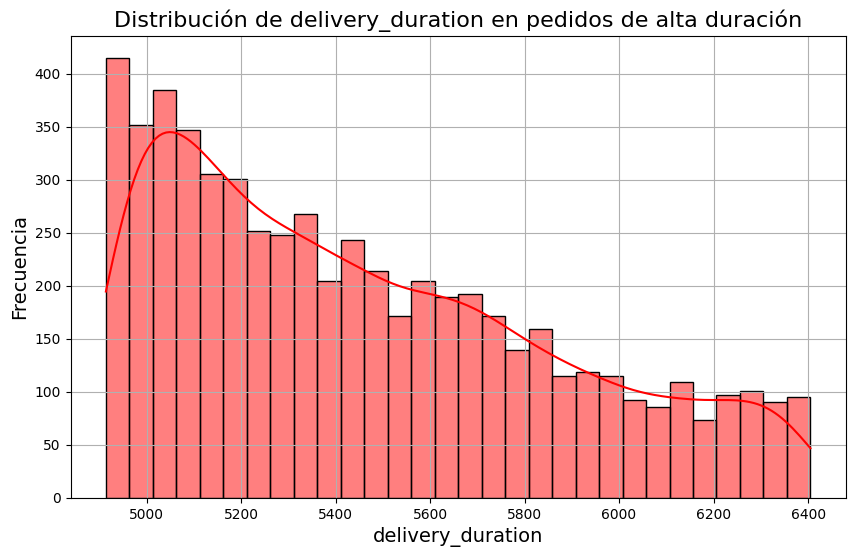

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_duration,partner_density,order_hour,busy_ratio,avg_item_price,order_period_encoded,log_delivery_duration,is_high_duration
count,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.0
mean,3.222013,2767.498205,2.745855,700.326098,1221.333789,42.271236,41.156042,68.781063,5456.944454,inf,5.916254,inf,1018.440494,2.636472,8.602138,1.0
std,2.249429,1425.138319,1.520295,530.886313,560.165668,36.541148,34.848670,63.209302,405.193158,NaN,7.230692,NaN,533.685988,0.795476,0.072922,0.0
min,1.000000,0.000000,1.000000,0.000000,99.000000,-1.000000,0.000000,-5.000000,4914.000000,-3.250000,0.000000,0.000000,0.000000,0.000000,8.500047,1.0
25%,2.000000,1628.000000,2.000000,300.000000,875.000000,12.000000,12.000000,17.000000,5107.000000,0.501931,2.000000,0.857143,675.900000,3.000000,8.538563,1.0
50%,3.000000,2500.000000,2.000000,595.000000,1125.000000,31.000000,31.000000,46.000000,5372.000000,0.600000,3.000000,0.953846,925.000000,3.000000,8.589142,1.0
75%,4.000000,3726.000000,4.000000,950.000000,1495.000000,65.000000,64.000000,107.000000,5738.500000,0.736842,4.000000,1.000000,1245.833333,3.000000,8.655127,1.0
max,48.000000,6400.000000,15.000000,5900.000000,5900.000000,158.000000,148.000000,278.000000,6405.000000,inf,23.000000,inf,5900.000000,3.000000,8.764990,1.0


In [218]:
# Cargar el archivo pedidos_alta_duracion.csv
high_duration_orders = pd.read_csv('pedidos_alta_duracion.csv')

# Verificar la estructura y contenido del dataset cargado
print(high_duration_orders.info())
print(high_duration_orders.head())

# Análisis descriptivo de los pedidos de alta duración
high_duration_stats = high_duration_orders.describe()

# Visualizar la distribución de la duración de entrega
plt.figure(figsize=(10, 6))
sns.histplot(high_duration_orders['delivery_duration'], kde=True, bins=30, color='red')
plt.title('Distribución de delivery_duration en pedidos de alta duración', fontsize=16)
plt.xlabel('delivery_duration', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.grid(True)
plt.show()

# Mostrar estadísticas descriptivas
high_duration_stats

In [167]:
# Entrenar el modelo con las nuevas características para pedidos normales
hgb_model_normal_updated = HistGradientBoostingRegressor(
    random_state=42,
    min_samples_leaf=1,
    max_iter=200,
    max_depth=5,
    learning_rate=0.1
)
hgb_model_normal_updated.fit(X_train_normal_updated, y_train_normal_updated)

# Realizo predicciones en el conjunto de prueba actualizado
y_pred_normal_updated = hgb_model_normal_updated.predict(X_test_normal_updated)

# Calculo las métricas de evaluación
mae_normal_updated = mean_absolute_error(y_test_normal_updated, y_pred_normal_updated)
mse_normal_updated = mean_squared_error(y_test_normal_updated, y_pred_normal_updated)
r2_normal_updated = r2_score(y_test_normal_updated, y_pred_normal_updated)

mae_normal_updated, mse_normal_updated, r2_normal_updated


(0.2189808390671275, 0.07499334939359951, 0.23469159936173511)

In [ ]:
normal_orders

***INTENTO CREO MATRIZ DE CORRELACIÓN CON COL. NUMERICAS Y VARIABLE LOGARITMICA CREADA***

In [90]:
# Selecciono únicamente las columnas numéricas
filtered_numeric_df = filtered_df.select_dtypes(include=['float64', 'int64'])

NameError: name 'filtered_df' is not defined

In [207]:
# Calculo la matriz de correlación con las columnas numéricas
correlation_matrix = filtered_numeric_df.corr()

In [208]:
# Extraigo las correlaciones con la variable objetivo
correlations_with_target = correlation_matrix['log_delivery_duration'].sort_values(ascending=False)

In [209]:
# Selecciono las características con alta correlación (por ejemplo, mayor a 0.1)
high_correlation_features = correlations_with_target[correlations_with_target.abs() > 0.1].index.tolist()

In [210]:
high_correlation_features

['delivery_duration',
 'log_delivery_duration',
 'is_high_duration',
 'total_outstanding_orders',
 'subtotal',
 'order_period_encoded',
 'num_distinct_items',
 'max_item_price',
 'total_busy_partners',
 'order_hour',
 'partner_density']

In [211]:
# Creo un nuevo conjunto de datos con las características seleccionadas
X_high_corr = filtered_numeric_df[high_correlation_features].drop(columns=['log_delivery_duration'])
y_high_corr = filtered_numeric_df['log_delivery_duration']

In [212]:
# Divido los datos en conjuntos de entrenamiento y prueba
X_train_high_corr, X_test_high_corr, y_train_high_corr, y_test_high_corr = train_test_split(
    X_high_corr, y_high_corr, test_size=0.2, random_state=42
)

In [ ]:
# Entreno el modelo con las características seleccionadas
hgb_model_high_corr = HistGradientBoostingRegressor(
    random_state=42,
    min_samples_leaf=20,
    max_iter=200,
    max_depth=5,
    learning_rate=0.1
)
hgb_model_high_corr.fit(X_train_high_corr, y_train_high_corr)

HistGradientBoostingRegressor(max_depth=5, max_iter=200, random_state=42)

In [214]:
# Realizo predicciones en el conjunto de prueba
y_pred_high_corr = hgb_model_high_corr.predict(X_test_high_corr)

# Calculo métricas de evaluación
mae_high_corr = mean_absolute_error(y_test_high_corr, y_pred_high_corr)
mse_high_corr = mean_squared_error(y_test_high_corr, y_pred_high_corr)
r2_high_corr = r2_score(y_test_high_corr, y_pred_high_corr)


print(f"MAE: {mae_high_corr}, MSE: {mse_high_corr}, R²: {r2_high_corr}")

MAE: 5.125301434258038, MSE: 117.72725889787914, R²: 0.9998714503152084


In [215]:
import joblib

In [217]:
# Guardo el modelo entrenado
joblib.dump(hgb_model_high_corr, 'm_tiempo_pedido_normal.pkl')

['m_tiempo_pedido_normal.pkl']

**Voy a hacer cross validation para garantizarme que no tenga overfitting el modelo**

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

In [ ]:
# Evaluo cruzando con el modelo entrenado para los pedidos normales
cross_val_scores = cross_val_score(hgb_model_high_corr, X_train_high_corr, y_train_high_corr, cv=5, scoring='r2')

In [220]:
# Calculo las métricas de cross validation
mean_r2_cross_val = np.mean(cross_val_scores)
std_r2_cross_val = np.std(cross_val_scores)

mean_r2_cross_val, std_r2_cross_val


(np.float64(0.9998514719456425), np.float64(7.217910552625016e-06))

NameError: name 'datos' is not defined